In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy.sparse as sp
import kwant
import tinyarray

## Defining Dots

In [2]:
lat = kwant.lattice.honeycomb(a = 1.0, norbs=2)
a_lat, b_lat = lat.sublattices
nnn_hoppings_a = (((-1, 0), a_lat, a_lat), ((0, 1), a_lat, a_lat), ((1, -1), a_lat, a_lat))
nnn_hoppings_b = (((1, 0), b_lat, b_lat), ((0, -1), b_lat, b_lat), ((-1, 1), b_lat, b_lat))
nnn_hoppings_all = nnn_hoppings_a + nnn_hoppings_b
lat_neighbors_2 = [kwant.builder.HoppingKind(*hop) for hop in nnn_hoppings_all]

def atan(y, x):
    ans = np.arctan2(y, x)
    if type ( x + 0.0) == type(y+0.0) and type(x+0.0) in [float, np.float64, np.float128, np.float_]:

        if ans < 0: return 2*np.pi + ans
        else: return ans

    elif type(x) == type(y) and type(x) == type(np.array([])) :
        ans[ans < 0] += 2*np.pi
        return ans

    else: raise TypeError("atan is getting neither floats nor arrays")


def create_graphene_circular_system(r, a=1.0, norb=1, t_prime = 0.0, p_edge = 0.0, U0 = 0.0):

    def deformed_circle(pos):
      R = np.linalg.norm(np.array([*pos]))
      angle = atan(pos[1], pos[0])
      return R < r + 0.2*r*np.sin(angle) + 0.05*r*np.sin(2*angle) - 0.025*r*np.sin(3*angle) + 0.02*r*np.sin(4*angle) - 0.01*r*np.sin(5*angle)

    sys = kwant.Builder()
    sys[lat.shape(deformed_circle, (0, 0))] = 0
    sys[lat.neighbors(n=1)] = -1.0

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    sites = list(sys.sites())
    edges = []
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections < 3: edges.append(s)
    print("Number of edges: ", len(edges))
    
    pp = True
    for edge_sites in edges:
      random_number = np.random.rand()
      if random_number < p_edge:
        if pp: 
            print("Edge site")
            pp = False
        sys[edge_sites] = U0
    
    

    if not np.allclose(t_prime, 0):
        sys[lat_neighbors_2] = -t_prime

    return sys

Number of edges:  1125
Number of edges:  1125
Number of edges:  1125
Edge site


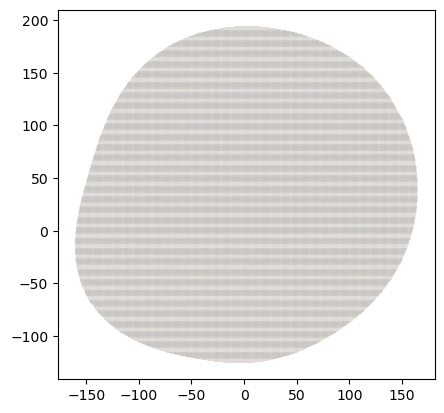

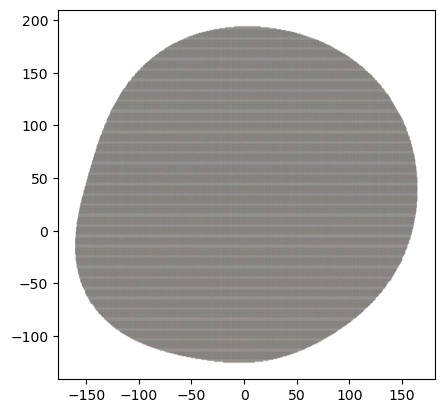

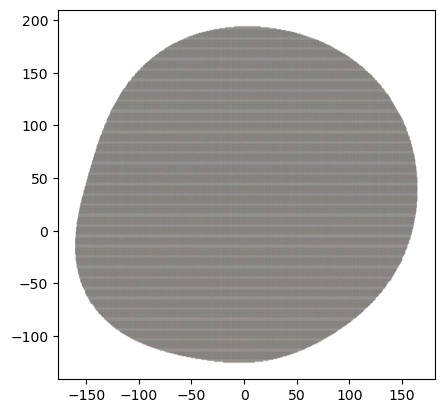

In [55]:
circular_dot = create_graphene_circular_system(r=160., t_prime=0.0)
circular_dot_edge1 = create_graphene_circular_system(r=160., t_prime=0.1, p_edge=0.0, U0=0.0)
circular_dot_edge2 = create_graphene_circular_system(r=160., t_prime=0.1, p_edge=1.0, U0=0.1)
kwant.plot(circular_dot)
kwant.plot(circular_dot_edge1)
kwant.plot(circular_dot_edge2)
plt.show()

In [56]:
gqd = circular_dot.finalized()
gqde1 = circular_dot_edge1.finalized()
gqde2 = circular_dot_edge2.finalized()
N = len(gqd.sites)
N

189605

In [57]:
h = gqd.hamiltonian_submatrix(sparse=True)
he1 = gqde1.hamiltonian_submatrix(sparse=True)
he2 = gqde2.hamiltonian_submatrix(sparse=True)

In [58]:
from scipy.io import savemat

# Export sparse matrices to MATLAB format
savemat('sparse_matrices.mat', {'h': h, 'he1': he1, 'he2': he2})

In [59]:
savemat("sparse_matrix_r160.mat", {"H": h})
savemat("sparse_matrix_r160_edge1.mat", {"H": he1})
savemat("sparse_matrix_r160_edge2.mat", {"H": he2})

## Python codes (do not run those locally for Large dots)

In [45]:
energies_ref= sla.eigsh(h, k=N-2, return_eigenvectors=False, sigma=1e-16)

In [46]:
energies= sla.eigsh(he1, k=N-2, return_eigenvectors=False, sigma=1e-16)

In [47]:
energies2= sla.eigsh(he2, k=N-2, return_eigenvectors=False, sigma=1e-16)

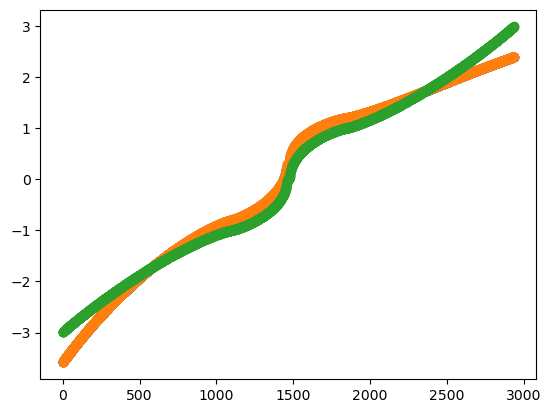

In [50]:
plt.scatter(range(len(energies)), np.sort(energies))
plt.scatter(range(len(energies2)), np.sort(energies2))
plt.scatter(range(len(energies2)), np.sort(energies_ref))
plt.show()

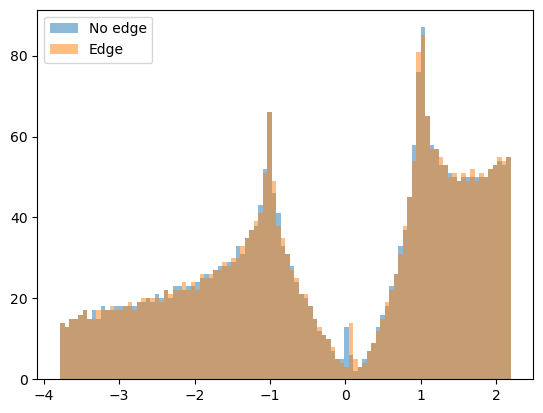

In [54]:
plt.hist(energies-0.2, bins=100, alpha=0.5, label='No edge')
# plt.hist(energies_ref, bins=100, alpha=0.5, label='Reference')
plt.hist(energies2-0.2, bins=100, alpha=0.5, label='Edge')
plt.legend()
plt.show()

### When $t' \in \mathbb{C}$

`nnn_hoppings` introduced a gap in the energy spectrum

`U0` then had no impact

## importing solutions from matlab

In [56]:
from scipy.io import loadmat
import os

In [ ]:
root = './matlab/MATLAB_DRIVE/'
f1, f2, f3 = root + 'eigenvalues_r160_edge_p00_nnn01_U0.txt', root + 'eigenvalues_r160_edge_p00_nnn01_U0_n2.txt', root + 'eigenvalues_r160_edge_p00_nnn01_U0_2.txt'
arrs = [np.loadtxt(f1), np.loadtxt(f2), np.loadtxt(f3)]

In [98]:
def combined_histogram(arr1, arr2, arr3):
    start = min(arr1.min(), arr2.min(), arr3.min())
    stop = max(arr1.max(), arr2.max(), arr3.max())
    dE = 0.00625
    bins = np.arange(start, stop, dE)
    freq = []
    for bin in bins:
        freq.append(max(np.sum(np.abs(arr1-bin) < dE/2), np.sum(np.abs(arr2-bin) < dE/2), np.sum(np.abs(arr3-bin) < dE/2)))
    
    histo = []
    for i, f in enumerate(freq):
        for _ in range(f):
            histo.append(bins[i] + 0.00125*np.random.rand())
    plt.hist(histo, bins = len(bins))
    plt.show()
    
    return bins, freq


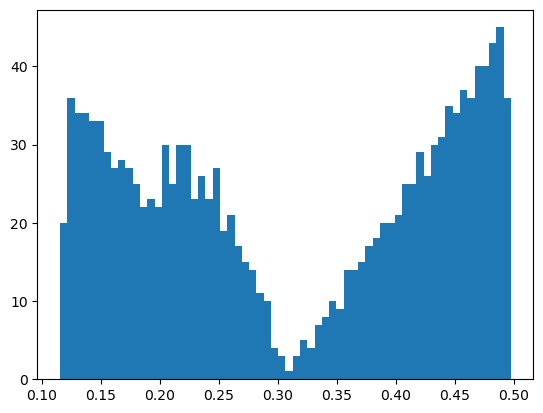

(array([0.11520369, 0.12145369, 0.12770369, 0.13395369, 0.14020369,
        0.14645369, 0.15270369, 0.15895369, 0.16520369, 0.17145369,
        0.17770369, 0.18395369, 0.19020369, 0.19645369, 0.20270369,
        0.20895369, 0.21520369, 0.22145369, 0.22770369, 0.23395369,
        0.24020369, 0.24645369, 0.25270369, 0.25895369, 0.26520369,
        0.27145369, 0.27770369, 0.28395369, 0.29020369, 0.29645369,
        0.30270369, 0.30895369, 0.31520369, 0.32145369, 0.32770369,
        0.33395369, 0.34020369, 0.34645369, 0.35270369, 0.35895369,
        0.36520369, 0.37145369, 0.37770369, 0.38395369, 0.39020369,
        0.39645369, 0.40270369, 0.40895369, 0.41520369, 0.42145369,
        0.42770369, 0.43395369, 0.44020369, 0.44645369, 0.45270369,
        0.45895369, 0.46520369, 0.47145369, 0.47770369, 0.48395369,
        0.49020369, 0.49645369]),
 [18,
  38,
  34,
  34,
  33,
  33,
  29,
  27,
  28,
  27,
  25,
  22,
  23,
  22,
  30,
  25,
  30,
  30,
  23,
  26,
  23,
  27,
  19,
  21,
  17,


In [99]:
combined_histogram(arrs[0], arrs[1], arrs[2])

In [100]:
root = './matlab/MATLAB_DRIVE/'
f1, f2, f3 = root + 'eigenvalues_r160_edge_p100_nnn01_U01.txt', root + 'eigenvalues_r160_edge_p100_nnn01_U01_n2.txt', root + 'eigenvalues_r160_edge_p100_nnn01_U01_2.txt'
arrs = [np.loadtxt(f1), np.loadtxt(f2), np.loadtxt(f3)]

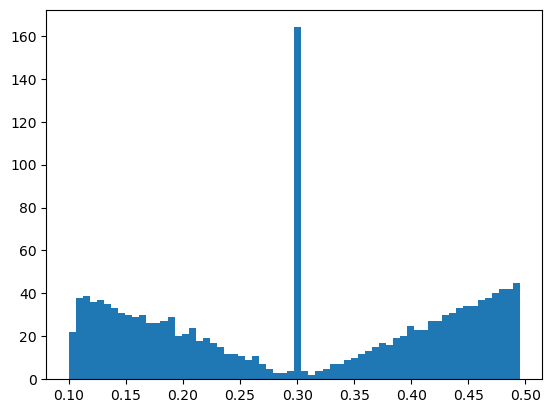

(array([0.10007474, 0.10632474, 0.11257474, 0.11882474, 0.12507474,
        0.13132474, 0.13757474, 0.14382474, 0.15007474, 0.15632474,
        0.16257474, 0.16882474, 0.17507474, 0.18132474, 0.18757474,
        0.19382474, 0.20007474, 0.20632474, 0.21257474, 0.21882474,
        0.22507474, 0.23132474, 0.23757474, 0.24382474, 0.25007474,
        0.25632474, 0.26257474, 0.26882474, 0.27507474, 0.28132474,
        0.28757474, 0.29382474, 0.30007474, 0.30632474, 0.31257474,
        0.31882474, 0.32507474, 0.33132474, 0.33757474, 0.34382474,
        0.35007474, 0.35632474, 0.36257474, 0.36882474, 0.37507474,
        0.38132474, 0.38757474, 0.39382474, 0.40007474, 0.40632474,
        0.41257474, 0.41882474, 0.42507474, 0.43132474, 0.43757474,
        0.44382474, 0.45007474, 0.45632474, 0.46257474, 0.46882474,
        0.47507474, 0.48132474, 0.48757474, 0.49382474]),
 [22,
  38,
  39,
  36,
  37,
  35,
  33,
  31,
  30,
  29,
  30,
  26,
  26,
  27,
  29,
  20,
  21,
  24,
  18,
  19,
  17,


In [101]:
combined_histogram(*arrs)

(array([ 46.,  48.,  49.,  37.,  43.,  40.,  40.,  36.,  33.,  34.,  28.,
         31.,  25.,  30.,  23.,  23.,  23.,  15.,  24.,  10.,  19.,  15.,
         12.,   9.,   8.,   8.,   6.,   4.,   3.,   4., 164.,   3.,   3.,
          2.,   5.,   6.,   8.,   9.,   8.,  12.,  15.,   8.,  20.,  17.,
         17.,  17.,  23.,  25.,  26.,  19.,  29.,  27.,  27.,  31.,  30.,
         31.,  38.,  40.,  32.,  44.,  38.]),
 array([-0.19806127, -0.19156755, -0.18507384, -0.17858012, -0.1720864 ,
        -0.16559268, -0.15909897, -0.15260525, -0.14611153, -0.13961781,
        -0.1331241 , -0.12663038, -0.12013666, -0.11364294, -0.10714923,
        -0.10065551, -0.09416179, -0.08766807, -0.08117436, -0.07468064,
        -0.06818692, -0.06169321, -0.05519949, -0.04870577, -0.04221205,
        -0.03571834, -0.02922462, -0.0227309 , -0.01623718, -0.00974347,
        -0.00324975,  0.00324397,  0.00973769,  0.0162314 ,  0.02272512,
         0.02921884,  0.03571256,  0.04220627,  0.04869999,  0.05519371,


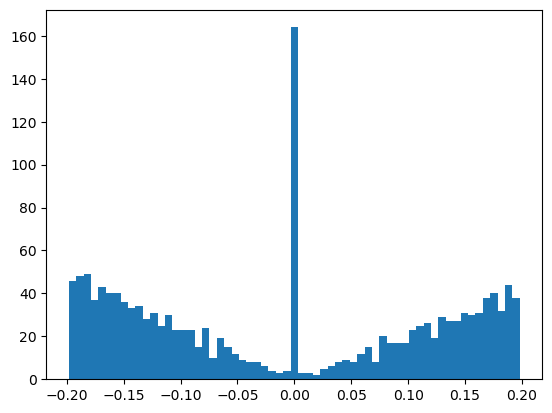

In [112]:
energies = np.loadtxt("./matlab/MATLAB_DRIVE/eigenvalues_r160_edge_p00_nnn00_U0.txt")
plt.hist(energies, bins=61)